In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

In [8]:
data = pd.read_csv("../dataset/train.csv")

# data = data[(data['warp_error'] != 9223372036854775807)]
# data = data[(data['warp_error'] != -1)]

# casos em que essa condição é atendida nunca são selecionados
# data = data[(data['warp_error'] / data['ref_frame_error']) < 0.65]

data.drop([
    'name',
    'cur_ref_count',
    'cur_showable_frame',
    'ref_showable_frame',
    'downsample_level',
    'num_refinements',
    'bit_depth'
], axis=1, inplace=True)

# Remove os valores constantes (0 variancia)
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(data)

constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]

data.drop(constant_columns, axis=1)

df = pd.DataFrame(data, columns=data.columns)

df

,distance,num_ref_frames,cq_level,cur_order_hint,ref_ref_count,ref_order_hint,src_width,src_height,src_stride,frame,...,alpha,beta,gamma,delta,seg_count,ref_frame_error,fast_error,warp_error,selected,inliers_rate
0,1,3,80,3,7,0,1280,720,1600,0,...,64.0,-64.0,64.0,64.0,282,13583723,8002826,7070073,1,0.789596
1,1,1,80,2,5,0,1280,720,1600,0,...,0.0,-64.0,64.0,0.0,312,12353545,6013827,4249018,1,0.995848
2,1,1,80,4,2,12,1280,720,1600,0,...,0.0,0.0,0.0,0.0,340,13120077,8719772,4404826,1,0.993794
3,1,2,80,4,2,2,1280,720,1600,0,...,0.0,-64.0,64.0,0.0,331,15298827,8171097,6394827,1,0.962245
4,1,1,80,5,2,12,1280,720,1600,0,...,0.0,0.0,0.0,0.0,335,13184703,8545519,4495996,1,0.996654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,1,1,220,26,2,16,1920,1080,2240,0,...,-128.0,64.0,-64.0,-128.0,138,1718698,1578452,1205863,0,0.270499
12988,1,1,220,26,2,24,1920,1080,2240,0,...,0.0,-64.0,64.0,0.0,165,1986437,1785728,1395885,0,0.320349
12989,1,1,220,28,2,16,1920,1080,2240,0,...,-128.0,64.0,-64.0,-128.0,157,1716537,1730596,1206860,0,0.308999
12990,1,1,220,28,2,26,1920,1080,2240,0,...,128.0,-64.0,64.0,128.0,166,1772204,1679260,1240632,0,0.344306


O dataset é extremamente desbalanceado

selected
1    9330
0    3662
Name: count, dtype: int64

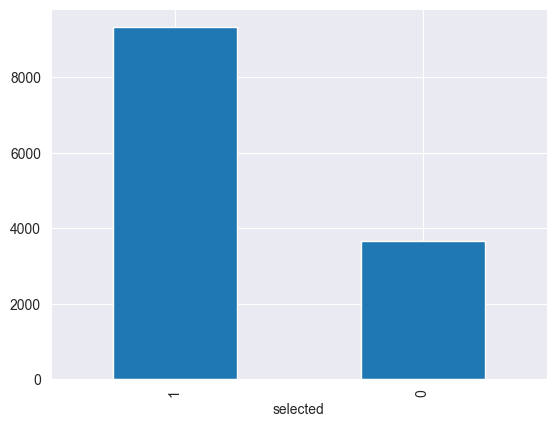

In [9]:
df['selected'].value_counts().plot(kind='bar')
df['selected'].value_counts()

Existe uma boa correlação entre o erro real é o erro rápido

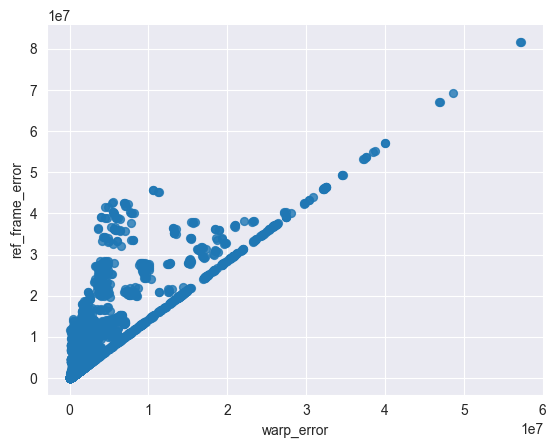

In [10]:
m_df = df.copy()

m_df.plot(kind='scatter', x='warp_error', y='ref_frame_error', s=32, alpha=.8)
plt.gca().spines[['top', 'right', ]].set_visible(False)

Quando a taxa de inliers é baixa, o fast_error erra por mais

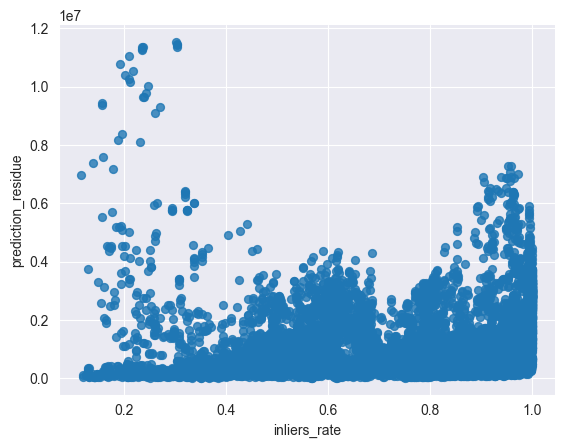

In [5]:
m_df = df.copy()

m_df['prediction_residue'] = m_df['fast_error'] - m_df['warp_error']

m_df.plot(kind='scatter', x='inliers_rate', y='prediction_residue', s=32, alpha=.8)
plt.gca().spines[['top', 'right', ]].set_visible(False)

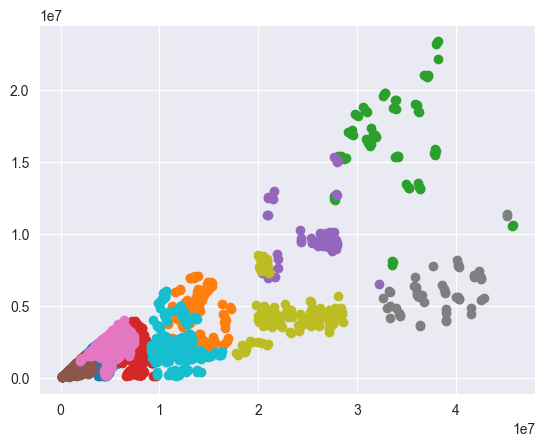

In [6]:
from sklearn.cluster import KMeans

m_df = df.copy()
n_clusters=10

m_df.drop(['warp_error'], axis=1, inplace=True)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
label = kmeans.fit_predict(m_df)

for n in range(n_clusters):
    filtered_label = df[label == n]
    plt.scatter(filtered_label['ref_frame_error'], filtered_label['warp_error'])

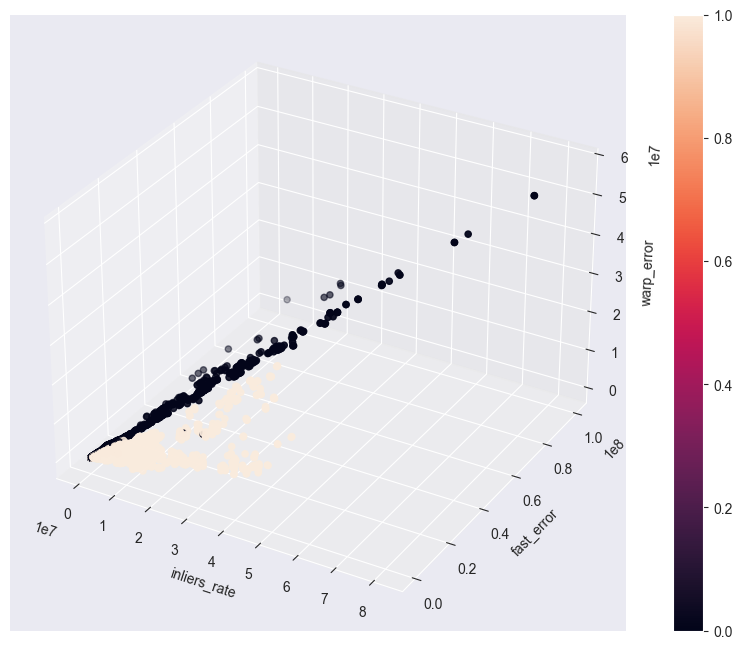

In [13]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter3D(df['ref_frame_error'], df['fast_error'], df['warp_error'], c=df['selected'])
cbar = plt.colorbar(pnt3d)
ax.set_xlabel('inliers_rate')
ax.set_ylabel('fast_error')
ax.set_zlabel('warp_error')
plt.show()